In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import math
from os import listdir
import data_visualization as dv
import pickle
import scipy 
from scipy.stats import norm
from scipy import stats
from tqdm import tqdm 
'''
This script was when I was testing if people reacted faster to the agent than they 
did to the targets popping up 
'''

'\nThis script was when I was testing if people reacted faster to the agent than they \ndid to the targets popping up \n'

Get blocks, trials, pull list

In [14]:
# Fields pull and pull list
experiment1 = 1
if experiment1 == 1:
    os.chdir('D:\Subject_Data\Exp1 Pilots\Target_Reaction_vs_Agent_Reaction')
PATH = os.getcwd()
analysis_pull_list_uniform = []
analysis_pull_list_normal = []
fields_pull = []
with open(PATH+"\\Analysis_Pull_List_Uniform.txt", "r") as pull_file:
    analysis_pull_list_uniform = pull_file.read().splitlines()
with open(PATH+"\\Analysis_Pull_List_Normal.txt", "r") as pull_file:
    analysis_pull_list_normal = pull_file.read().splitlines()
with open(PATH+"\\Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()

# SPECIFIC TO EXPERIMENT
uniform_trials = 50
uniform_blocks = 2
normal_trials = 50
normal_blocks = 1
tot_uniform_trials = uniform_trials*uniform_blocks
tpt_normal_trials = normal_blocks*normal_trials
data_columns = len(fields_pull)
trial_time = 1500
num_subjects = len(analysis_pull_list_uniform)



Get Target info

In [15]:
file = PATH+'\\Sub1_Uniform\\Sub1_UniformTarget_Table.csv'
df = pd.read_csv(file)
df["X"] = df["X"]/100
df["Y"] = df["Y"]/100
df['Dim 1'] = df['Dim 1']/100 # Target table is in centimeters, I guess this doesn't matter but it makes me feel better
df['Dim 2'] = df['Dim 2']/100
# Target information for Right Hand (keeping this because the positions of target 3 and 4 are based on target 1 and start 1)
start1x = df.loc[0]['X']
start1y = df.loc[0]['Y']
start1_radius = df.loc[0]['Dim 1'] 

target1x = df.loc[1]['X']
target1y = df.loc[1]['Y']
t1_pos = np.sqrt(target1x**2 + target1y**2)
target1_radius = df.loc[1]['Dim 1']

target2x = 2*start1x - target1x
target2y = target1y
t2_pos = np.sqrt(target2x**2 + target2y**2)
target2_radius = target1_radius

Analyze Uniform Distribution Trials

In [16]:
trial_time = 2000
rt_decision_array_uniform = np.empty((num_subjects,uniform_blocks,uniform_trials))
rmt_decision_array_uniform = np.empty((num_subjects, uniform_blocks,uniform_trials))
rt_trial_start_uniform = np.zeros((num_subjects, uniform_blocks,uniform_trials))*np.nan
reaction_movement_time_uniform = np.zeros([num_subjects, uniform_blocks,uniform_trials])*np.nan
reaction_time_uniform = np.zeros([num_subjects, uniform_blocks,uniform_trials])*np.nan
rt_hand_pos_data_uniform = np.zeros((num_subjects, uniform_blocks, uniform_trials, trial_time, 4))*np.nan
agent_decision_time_uniform = np.empty((num_subjects,uniform_blocks,uniform_trials))
timing_reach_time = np.zeros([num_subjects, uniform_blocks,uniform_blocks])*np.nan
for w in range(num_subjects):
    sub_name = analysis_pull_list_uniform[w]
    print(w, sub_name)
    block_number = 1
    tp_num = 1
    sub_name = analysis_pull_list_uniform[w]
    path1 = PATH+'\\'+sub_name
    file = path1+f'\\{sub_name}Trial_Table.csv'
    reaction_trial_table = pd.read_csv(file)
    min_tp_num = np.min(reaction_trial_table['TP_Row'].unique()) # Gets minimum tp number and subtracts it off... keeps conditions in the same order, with first tp always being at index 0
    #reaction_trial_table = reaction_trial_table.loc[reaction_trial_table['TP_Row']==1]
    
    for i in tqdm((range(tot_uniform_trials))):
        block_number = reaction_trial_table.iloc[i]['Block_Row']
        tp_num = reaction_trial_table.iloc[i]['TP_Row']
        block_trial_num = reaction_trial_table.iloc[i]['Block_Step']
        x = tp_num - min_tp_num
        c = block_trial_num - 1
        filename = PATH+f"\\{sub_name}\\Target_Reaction_vs_Agent_Reaction_{sub_name}_C{block_number}_TP{tp_num}_T{block_trial_num}.csv"

        data = pd.read_csv(filename, low_memory=False)
        if reaction_trial_table.iloc[i]['Condition type'] == 0:
            rt_trial_start_uniform[w,x,c]= int(data[data['Event_Codes']=='E_SOUND_SIGNAL'].index[0]) #if event codes column is equal to the list event codes, give the index (time)
            rt_trial_start_uniform[w,x,c] = rt_trial_start_uniform[w,x,c].astype(int)
            end_time = rt_trial_start_uniform[w,x,c]+trial_time

            data = np.array(data)
            hand_data = data[:,0:4] # data is only columns 0 thru 3 (RHX,RHY,LHX,LHY)
            hand_data = hand_data.astype(float)
            hand_data_constrained = hand_data[rt_trial_start_uniform[w,x,c]:end_time,:] # Constrain to length of trial 
            # If the hand_data_constrained is less than 2000, then place nans on the end with np.append
            if hand_data_constrained.shape[0]<2000:
                print(hand_data_constrained.shape)
                extra_nan_length = 2000 - hand_data_constrained.shape[0]
                print(len([np.nan]*extra_nan_length))
                hand_data_constrained = np.append(hand_data_constrained,np.zeros((extra_nan_length,4))*np.nan, axis = 0)
                print(np.shape(hand_data_constrained))
            rt_hand_pos_data_uniform[w,x,c,:,:] = hand_data_constrained
            # LEFT HAND
            lhx = rt_hand_pos_data_uniform[w,x,c,:,2]
            lhy = rt_hand_pos_data_uniform[w,x,c,:,3]
            
            q = np.argwhere(np.sqrt((lhx-target1x)**2 + (lhy-target1y)**2) < target1_radius)
            r = np.argwhere(np.sqrt((lhx-target2x)**2 + (lhy-target2y)**2) < target2_radius) 
            s = np.argwhere(np.sqrt((lhx-start1x)**2 + (lhy-start1y)**2) > start1_radius)
            if np.size(s)>0: 
                reaction_time_uniform[w,x,c] = s[0]
            if np.size(q)>0: #if LH enters right target
                rmt_decision_array_uniform[w,x,c] = 1
                reaction_movement_time_uniform[w,x,c] = q[0]
            elif np.size(r)>0: #if LH enters left target
                rmt_decision_array_uniform[w,x,c] = -1   
                reaction_movement_time_uniform[w,x,c] = r[0]
                
        elif reaction_trial_table.iloc[i]['Condition type'] == 2:
            rt_trial_start_uniform[w,x,c]= int(data[data['Event_Codes']=='E_SOUND_SIGNAL'].index[0]) #if event codes column is equal to the list event codes, give the index (time)
            rt_trial_start_uniform = rt_trial_start_uniform.astype(int)
            end_time = rt_trial_start_uniform[w,x,c] + 2000
            agent_decision_time_uniform[w,x,c] = data.iloc[rt_trial_start_uniform[w,x,c]+1]['Agent_Reach_Time'] - 150
            data = np.array(data)
            hand_data = data[:,0:4] # data is only columns 0 thru 3 (RHX,RHY,LHX,LHY)
            hand_data = hand_data.astype(float)
            
            hand_data_constrained = hand_data[rt_trial_start_uniform[w,x,c]:end_time,:] # Constrain to length of trial 
            # If the hand_data_constrained is less than 2000, then place nans on the end with np.append
            if hand_data_constrained.shape[0]<2000:
                print(hand_data_constrained.shape)
                extra_nan_length = 2000 - hand_data_constrained.shape[0]
                print(len([np.nan]*extra_nan_length))
                hand_data_constrained = np.append(hand_data_constrained,np.zeros((extra_nan_length,4))*np.nan, axis = 0)
                print(np.shape(hand_data_constrained))
            rt_hand_pos_data_uniform[w,x,c,:,:] = hand_data_constrained
            # LEFT HAND
            lhx = rt_hand_pos_data_uniform[w,x,c,:,2]
            lhy = rt_hand_pos_data_uniform[w,x,c,:,3]
            
            q = np.argwhere(np.sqrt((lhx-target1x)**2 + (lhy-target1y)**2) < target1_radius)
            r = np.argwhere(np.sqrt((lhx-target2x)**2 + (lhy-target2y)**2) < target2_radius) 
            s = np.argwhere(np.sqrt((lhx-start1x)**2 + (lhy-start1y)**2) > start1_radius*1.2)
            if np.size(s)>0: 
                reaction_time_uniform[w,x,c] = s[0] - agent_decision_time_uniform[w,x,c]
            if np.size(q)>0: #if LH enters right target
                rmt_decision_array_uniform[w,x,c] = 1
                reaction_movement_time_uniform[w,x,c] = q[0]
            elif np.size(r)>0: #if LH enters left target
                rmt_decision_array_uniform[w,x,c] = -1   
                reaction_movement_time_uniform[w,x,c] = r[0]

        


0 Sub1_Uniform


 54%|█████▍    | 54/100 [00:01<00:01, 29.34it/s]

(1463, 4)
537
(2000, 4)


100%|██████████| 100/100 [00:03<00:00, 30.39it/s]


1 Sub2_Uniform


100%|██████████| 100/100 [00:04<00:00, 24.49it/s]


2 Sub3_Uniform


  5%|▌         | 5/100 [00:00<00:02, 46.79it/s]

(1500, 4)
500
(2000, 4)


100%|██████████| 100/100 [00:01<00:00, 51.76it/s]


Analyze Normal Distribution Condition

In [17]:
trial_time = 2000
rt_decision_array_normal = np.empty((num_subjects,normal_blocks,normal_trials))
rmt_decision_array_normal = np.empty((num_subjects, normal_blocks,normal_trials))
rt_trial_start_normal = np.zeros((num_subjects, normal_blocks,normal_trials))*np.nan
reaction_movement_time_normal = np.zeros([num_subjects, normal_blocks,normal_trials])*np.nan
reaction_time_normal = np.zeros([num_subjects, normal_blocks,normal_trials])*np.nan
rt_hand_pos_data_normal = np.zeros((num_subjects, normal_blocks, normal_trials, trial_time, 4))*np.nan
agent_decision_time_normal = np.empty((num_subjects,normal_blocks,normal_trials))
timing_reach_time = np.zeros([num_subjects, normal_blocks,normal_blocks])*np.nan
for w in range(num_subjects):
    sub_name = analysis_pull_list_normal[w]
    print(w, sub_name)
    block_number = 1
    tp_num = 1
    sub_name = analysis_pull_list_normal[w]
    path1 = PATH+'\\'+sub_name
    file = path1+f'\\{sub_name}Trial_Table.csv'
    reaction_trial_table = pd.read_csv(file)
    min_tp_num = np.min(reaction_trial_table['TP_Row'].unique()) # Gets minimum tp number and subtracts it off... keeps conditions in the same order, with first tp always being at index 0
    #reaction_trial_table = reaction_trial_table.loc[reaction_trial_table['TP_Row']==1]
    
    for i in tqdm((range(normal_trials))):
        block_number = reaction_trial_table.iloc[i]['Block_Row']
        tp_num = reaction_trial_table.iloc[i]['TP_Row']
        block_trial_num = reaction_trial_table.iloc[i]['Block_Step']
        x = tp_num - min_tp_num
        c = block_trial_num - 1
        filename = PATH+f"\\{sub_name}\\Target_Reaction_vs_Agent_Reaction_{sub_name}_C{block_number}_TP{tp_num}_T{block_trial_num}.csv"
        data = pd.read_csv(filename, low_memory=False)
                
        rt_trial_start_normal[w,x,c]= int(data[data['Event_Codes']=='E_SOUND_SIGNAL'].index[0]) #if event codes column is equal to the list event codes, give the index (time)
        rt_trial_start_normal = rt_trial_start_normal.astype(int)
        end_time = rt_trial_start_normal[w,x,c] + 2000
        agent_decision_time_normal[w,x,c] = data.iloc[rt_trial_start_normal[w,x,c]+1]['Agent_Reach_Time'] - 150
        data = np.array(data)
        hand_data = data[:,0:4] # data is only columns 0 thru 3 (RHX,RHY,LHX,LHY)
        hand_data = hand_data.astype(float)
        
        hand_data_constrained = hand_data[rt_trial_start_normal[w,x,c]:end_time,:] # Constrain to length of trial 
        # If the hand_data_constrained is less than 2000, then place nans on the end with np.append
        if hand_data_constrained.shape[0]<2000:
            print(hand_data_constrained.shape)
            extra_nan_length = 2000 - hand_data_constrained.shape[0]
            print(len([np.nan]*extra_nan_length))
            hand_data_constrained = np.append(hand_data_constrained,np.zeros((extra_nan_length,4))*np.nan, axis = 0)
            print(np.shape(hand_data_constrained))
        rt_hand_pos_data_normal[w,x,c,:,:] = hand_data_constrained
        # LEFT HAND
        lhx = rt_hand_pos_data_normal[w,x,c,:,2]
        lhy = rt_hand_pos_data_normal[w,x,c,:,3]
        
        q = np.argwhere(np.sqrt((lhx-target1x)**2 + (lhy-target1y)**2) < target1_radius)
        r = np.argwhere(np.sqrt((lhx-target2x)**2 + (lhy-target2y)**2) < target2_radius) 
        s = np.argwhere(np.sqrt((lhx-start1x)**2 + (lhy-start1y)**2) > start1_radius*1.2)
        if np.size(s)>0: 
            reaction_time_normal[w,x,c] = s[0] - agent_decision_time_normal[w,x,c]
        if np.size(q)>0: #if LH enters right target
            rmt_decision_array_normal[w,x,c] = 1
            reaction_movement_time_normal[w,x,c] = q[0]
        elif np.size(r)>0: #if LH enters left target
            rmt_decision_array_normal[w,x,c] = -1   
            reaction_movement_time_normal[w,x,c] = r[0]


0 Sub1_Normal


100%|██████████| 50/50 [00:00<00:00, 58.26it/s]


1 Sub2_Normal


100%|██████████| 50/50 [00:00<00:00, 56.84it/s]


2 Sub3_Normal


100%|██████████| 50/50 [00:00<00:00, 54.26it/s]


In [18]:
np.shape(reaction_movement_time_uniform)

(3, 2, 50)

In [19]:
n = 0
mean_reaction_time_uniform_two_target = np.mean(reaction_time_uniform[:,:,n:], axis = 2)[:,1]
mean_reaction_time_uniform_agent = np.mean(reaction_time_uniform[:,:,n:], axis = 2)[:,0]
mean_reaction_time_normal = np.mean(reaction_time_normal[:,:,n:], axis = 2)[:,0]

Plot Reaction Times for Each Condition

In [20]:
plt.style.use('cashaback_dark')

In [21]:
all_reaction_times = np.vstack((mean_reaction_time_uniform_agent, mean_reaction_time_uniform_two_target, mean_reaction_time_normal))
all_reaction_times

array([[303.2023645 , 389.42967773, 327.159104  ],
       [325.        , 376.26      , 314.04      ],
       [316.90654175, 397.35731445, 337.06030884]])

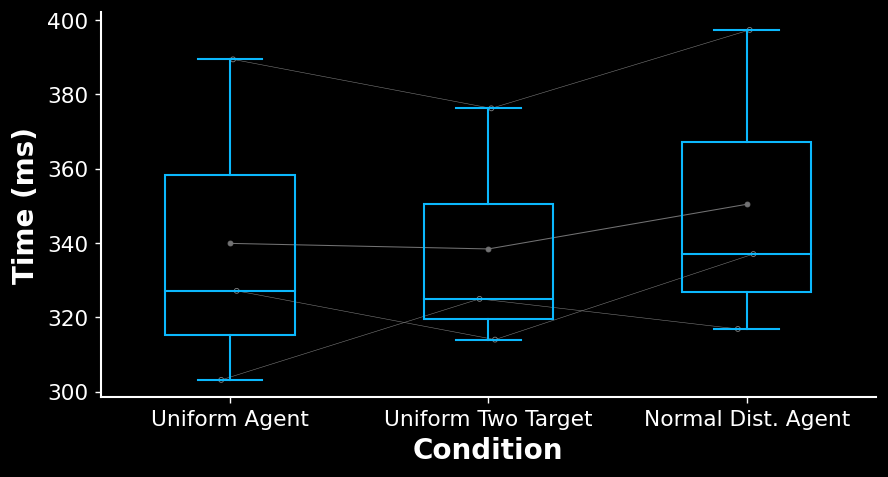

In [22]:
fig, ax = plt.subplots(dpi = 125, figsize=(8,4))
dv.boxplot(mean_reaction_time_uniform_agent, ax=ax,x_pos = 0)
dv.boxplot(mean_reaction_time_uniform_two_target, ax=ax,x_pos=1)
dv.boxplot(mean_reaction_time_normal, ax=ax, x_pos = 2)
dv.jitter_array(ax = ax, data_list = all_reaction_times, x_positions=[0,1,2],noise_scale = 0.1)
ax.set_xticklabels(['Uniform Agent', 'Uniform Two Target', 'Normal Dist. Agent'])
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Condition')
plt.show()